In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import log_loss, recall_score, confusion_matrix, precision_score
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [2]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# Data Preprocessing

In [3]:
# Replace BMI Null values by their mean
mean_bmi = df['bmi'].mean()
df['bmi'].fillna(mean_bmi, inplace=True)
df['bmi'] = df['bmi'].round(2)

#Categorize features gender, residence_type, work_type
df['gender'] = df['gender'].replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)
df['Residence_type'] = df['Residence_type'].replace({'Rural':0,'Urban':1}).astype(np.uint8)
df['work_type'] = df['work_type'].replace({'Private':0,'Self-employed':1,'Govt_job':2,'children':-1,'Never_worked':-2}).astype(np.uint8)
df['smoking_status'] =  df['smoking_status'].replace({'never smoked':0, 'formerly smoked':1, 'smokes':2, 'Unknown': -1 }).astype(np.uint8)

/var/folders/0f/s9wq33q97413q_m4638c7wdr0000gn/T/ipykernel_95295/3929226885.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].fillna(mean_bmi, inplace=True)
/var/folders/0f/s9wq33q97413q_m4638c7wdr0000gn/T/ipykernel_95295/3929226885.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[

In [4]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,0,67.0,0,1,Yes,0,1,228.69,36.60,1,1
1,51676,1,61.0,0,0,Yes,1,0,202.21,28.89,0,1
2,31112,0,80.0,0,1,Yes,0,0,105.92,32.50,0,1
3,60182,1,49.0,0,0,Yes,0,1,171.23,34.40,2,1
4,1665,1,79.0,1,0,Yes,1,0,174.12,24.00,0,1


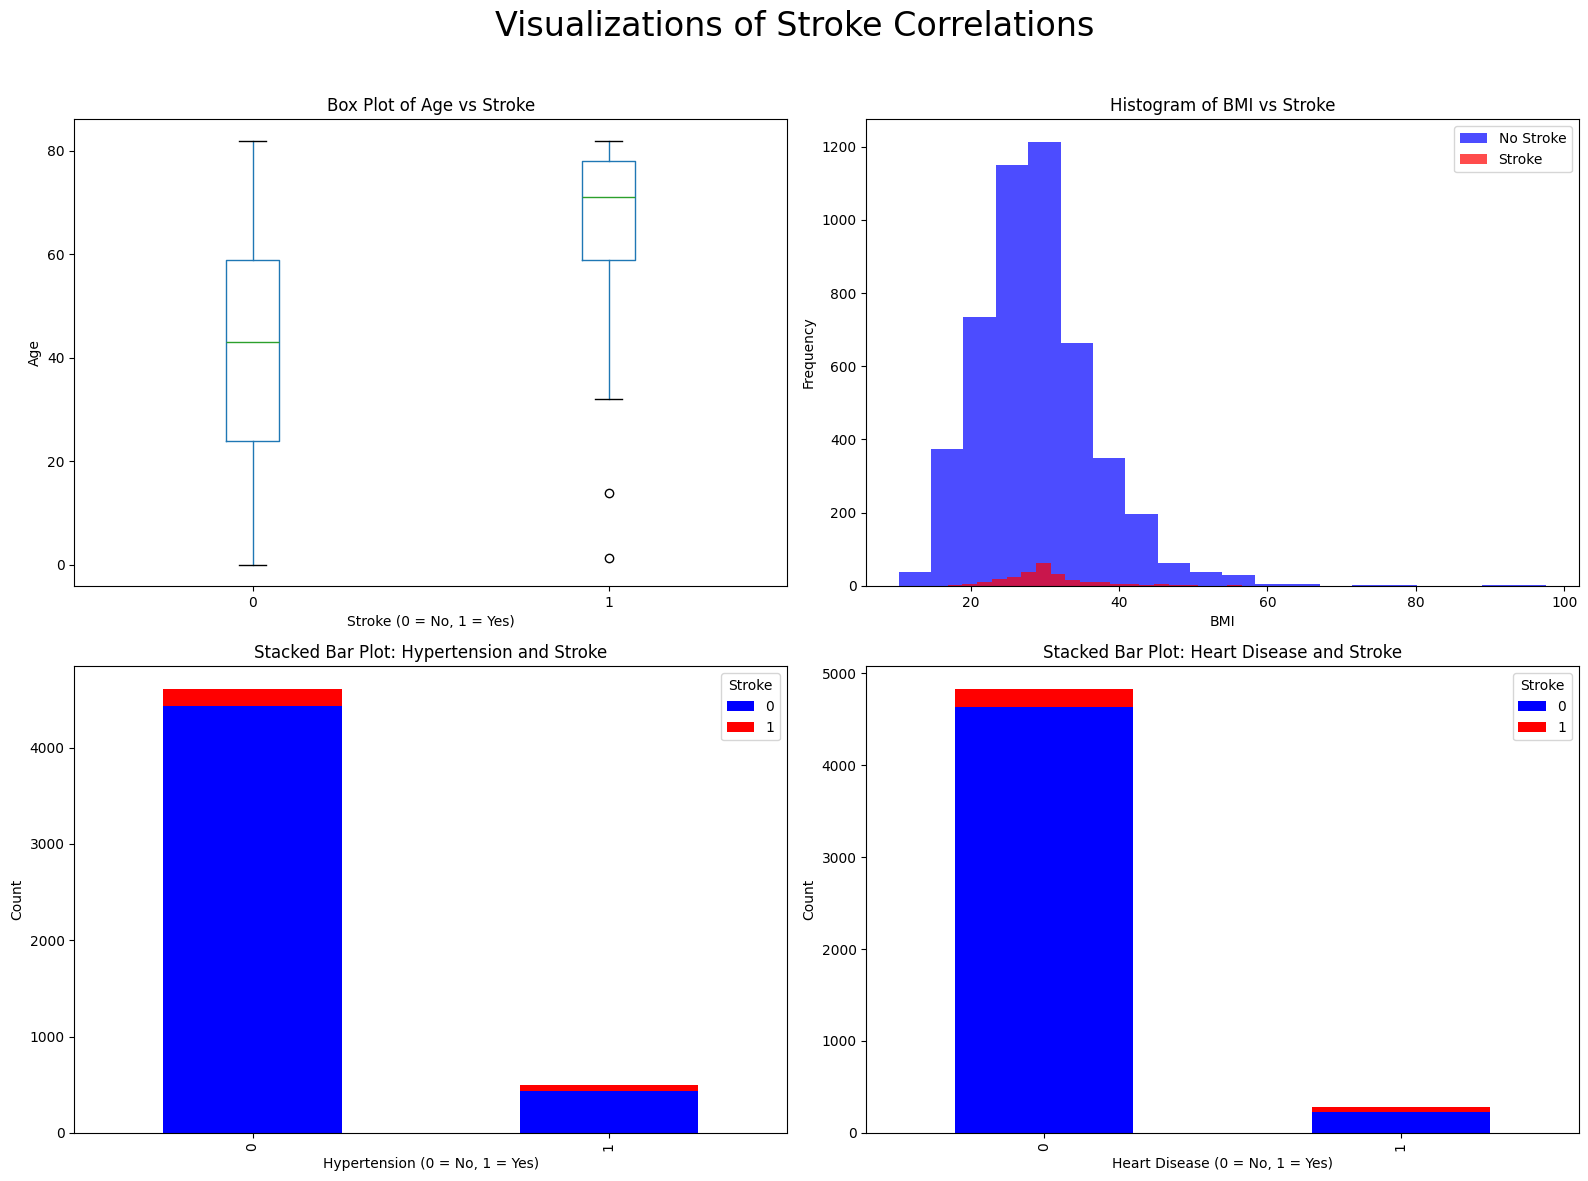

In [5]:
# Feature engineering by using visualization
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Box plot of Age vs Stroke
df.boxplot(column='age', by='stroke', grid=False, ax=axs[0, 0])
axs[0, 0].set_title('Box Plot of Age vs Stroke')
axs[0, 0].set_xlabel('Stroke (0 = No, 1 = Yes)')
axs[0, 0].set_ylabel('Age')

# Histogram of BMI vs Stroke
axs[0, 1].hist(df[df['stroke'] == 0]['bmi'], bins=20, alpha=0.7, label='No Stroke', color='blue')
axs[0, 1].hist(df[df['stroke'] == 1]['bmi'], bins=20, alpha=0.7, label='Stroke', color='red')
axs[0, 1].set_title('Histogram of BMI vs Stroke')
axs[0, 1].set_xlabel('BMI')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].legend()

# Stacked Bar Plot: Hypertension and Stroke
hypertension_stroke = pd.crosstab(df['hypertension'], df['stroke'])
hypertension_stroke.plot(kind='bar', stacked=True, ax=axs[1, 0], color=['blue', 'red'])
axs[1, 0].set_title('Stacked Bar Plot: Hypertension and Stroke')
axs[1, 0].set_xlabel('Hypertension (0 = No, 1 = Yes)')
axs[1, 0].set_ylabel('Count')
axs[1, 0].legend(title='Stroke')

# Stacked Bar Plot: Heart Disease and Stroke
heart_disease_stroke = pd.crosstab(df['heart_disease'], df['stroke'])
heart_disease_stroke.plot(kind='bar', stacked=True, ax=axs[1, 1], color=['blue', 'red'])
axs[1, 1].set_title('Stacked Bar Plot: Heart Disease and Stroke')
axs[1, 1].set_xlabel('Heart Disease (0 = No, 1 = Yes)')
axs[1, 1].set_ylabel('Count')
axs[1, 1].legend(title='Stroke')

# Adjust layout and display the figure
plt.suptitle('Visualizations of Stroke Correlations', fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [18]:
X  = df.drop(columns = ['id', 'ever_married', 'stroke'])
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)


In [17]:
oversample = SMOTE(random_state=42)
X_train_resh, y_train_resh = oversample.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resh)

rf_model = RandomForestClassifier(random_state=42)
logreg_model = LogisticRegression(random_state=42)

kf = KFold(n_splits=10, shuffle=True, random_state=42)

rf_scores = cross_val_score(rf_model, X_train_scaled, y_train_resh, cv=kf, scoring='recall')
logreg_scores = cross_val_score(logreg_model, X_train_scaled, y_train_resh, cv=kf, scoring='recall')

print('Mean Recall Scores:')
print('Random Forest mean:', rf_scores.mean())
print('Logistic Regression mean:', logreg_scores.mean())



Mean Recall Scores:
Random Forest mean: 0.9603143962152526
Logistic Regression mean: 0.8324255840583923


In [19]:
rf_model.fit(X_train_scaled, y_train_resh)
logreg_model.fit(X_train_scaled, y_train_resh)

X_test_scaled = scaler.transform(X_test)

y_predict_rf = rf_model.predict(X_test_scaled)
y_predict_lr = logreg_model.predict(X_test_scaled)

print(recall_score(y_test, y_predict_rf, pos_label=1))
print(recall_score(y_test, y_predict_lr, pos_label=1))

0.1774193548387097
0.5967741935483871


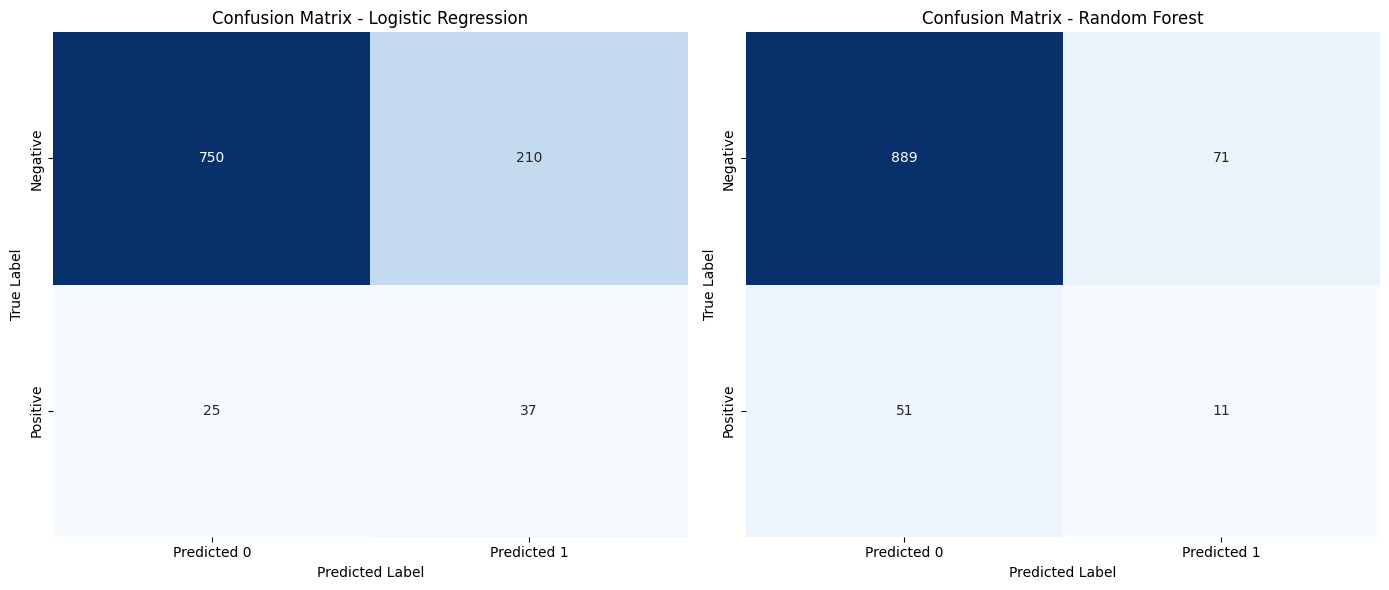

In [14]:
cm_log_reg = confusion_matrix(y_test, y_predict_lr)
cm_rf = confusion_matrix(y_test, y_predict_rf)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))


sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0],
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Negative', 'Positive'])
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title('Confusion Matrix - Logistic Regression')

# Random Forest Confusion Matrix
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1],
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Negative', 'Positive'])
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_title('Confusion Matrix - Random Forest')

plt.tight_layout()
plt.show()